# Neural Network

## I. Import and Load Data

Training Data was pulled from two sources. 

Solar Irradience data was pulled from the [National Solar Radiation Database](https://nsrdb.nrel.gov/). Pointwise GHI, DHI, and DNI data is returned hourly for an entire calendar year. All irradience values are recorded in w/m^2. Location is for a latitude longitude coordinate pair. Coordinates were chosen based on the locations of [U.S. Climate Reference Network (USCRN)](https://www.ncdc.noaa.gov/crn/) monitoring stations. This is because the USCRN has real time measurements of GHI, which can be used to make real-time predictions of DHI. The NRSDB is not updated so frequently. 

The production prediction module in the [omf](https://github.com/dpinney/omf/wiki) uses GHI measuremeants read from USCRN. 

In addition to solar irradience data, this project uses other weather data such as cloud cover, air pressure, and season data to try and model the relationship between GHI and DHI. For that, this project pulls data from [darksky](https://darksky.net/dev). And that data is combined with the NRSDB data for testing.

Please NOTE! In this notebook, the directory "Testing_Data" does not mean it is solely Testing Data. Rather for this Neural network, it contains both testing and training data. This is because the neural network requires much more data to train than regression. So much of the same data used to test the regression model is now being used to train the neural network. The True training data for the neural network is in "Proudction_Test", where the data is from USCRN and combined with data combed from darksky.

In [63]:
import pandas as pd
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
from random import randint
from glob import glob


In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [65]:
def featureHistograms(df, features=['GHI','DHI','Cloud Cover'],):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(ncols=len(features))
    for i in range(len(features)):
        sns.distplot(df[features[i]], ax=axs[i])

In [66]:
#Lets try and make a neural network

In [67]:
#Get 2018 Data
_Curr_Dir = os.getcwd()
_Testing_Data_Dir = os.path.join(_Curr_Dir, 'Testing_Data')
print(_Testing_Data_Dir)

/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data


In [68]:
pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_south_dakota', 'psm_testing_data2018.csv')).head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,timestamps,Cloud Cover
0,2018,1,1,0,30,-22.5,0,0,0,8,...,0,62.75,103.76,0.69,978,0.1,296,2.1,1514739600,0.0
1,2018,1,1,1,30,-23.1,0,0,0,0,...,0,66.39,114.24,0.69,978,0.1,287,2.2,1514743200,0.0
2,2018,1,1,2,30,-23.6,0,0,0,8,...,0,69.34,125.01,0.69,978,0.1,283,2.3,1514746800,0.0
3,2018,1,1,3,30,-23.9,0,0,0,8,...,0,71.25,135.74,0.69,978,0.1,283,2.3,1514750400,0.0
4,2018,1,1,4,30,-24.1,0,0,0,8,...,0,72.87,145.93,0.69,979,0.1,284,2.3,1514754000,0.0


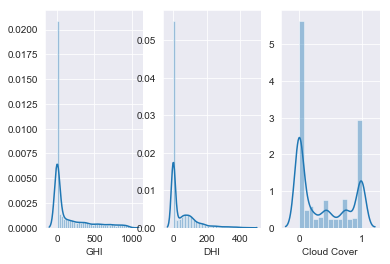

In [69]:
df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_south_dakota', 'psm_testing_data2018.csv'))
featureHistograms(df)

## II. Features and Data Engineering

So we have all the above variables....Which ones do we think would work best in a NN?

So we want to predict DHI, at the very least. Maybe DNI as well. What can we use to predict? 
[More Information on GHI, DHI, and DNI here!](https://firstgreenconsulting.wordpress.com/2012/04/26/differentiate-between-the-dni-dhi-and-ghi/#:~:text=Global%20Horizontal%20Irradiance%20(GHI)%20is,Diffuse%20Horizontal%20Irradiance%20(DHI).)

But a useful relationship to keep in mind is:

*Global Horizontal (GHI) = Direct Normal (DNI) X cos(θ) + Diffuse Horizontal (DHI)*

**GHI** is a must, as it is the primary metric our sensors will feed into such a model. 

**Cloud cover** is also essential, as cloud cover is one of the primary factors in how much direct normal solar irradience is diffused.

**Solar Zenith Angle** is important as it dictates how much irradience is direct normal (DNI)

Another useful relatinship to capture is **time**. We are given timestamps in addition to month, day, year, second, hour and minute variables. Timestamps and/or a combination between day + month would not be super useful, as it would overfit to the day. 
A more useful relationship would be to capture time of day. This is useful because in a non - featurized dataset, many GHI readings will read '0', simply because it is dark out. We are primarily concerned about the relationship between GHI and DHI, therefore factoring in readings when there is no sunlight to begin with could be confounding. Therefore adding in **minute** and **hour** variables in the input vector could adequately capture this relationship. 

Another solution would be to featurize this dataset, whereby we create a seperate feature which is a combination of day + time. OR, we could completly remove the nighttime entries entirely to ensure we only are concerned with readings that occur when the sun is out. However this occurs on a gradient, because sunlight is defracted even after sunset. So for now, let's just fit the model on the unedited dataset. 

Another good idea is to create a **season** variable, which is a dummy variable for each season (Fall, Winter, Spring, Summer), as different amounts of sunlight occur during each. The problem is that, for different locations on earth, seasonality could be inversely correlated with sunlight and thus GHI, DHI, and DNI. 

To keep the model as general as possible, we will exclude seasonality. 

Another useful metric is **Pressure**. According to the renowned [DISC model](https://www.nrel.gov/docs/legosti/old/3087.pdf), air pressure is included as a proxy for *air mass*, which is the amount of atmosphere solar rays have to travel through. The larger the solar mass, the more solar rays are scattered. 



### Loading the Data

Get training arrays and combine them into a useable vector

-Useful params:  
-Hours  
-Cloud Cover  
-GHI  
-Solar Zenith  
-Pressure  


Training Locations with Lat/Lon:  
-**Reliance, South Dakota** (43.85, -99.50) from 2010-2018  
-**Everglades, FL** (26.004157 ,-81.119239) from 2010-2018  
-**Spokane, WA** (47.41,-117.52) from 2010-2018  
-**Austin, TX** (30.581736,-98.024098) from 2010-2018  
-**Charlottesville, VA** (38.0086,-78.4532) from 2010-2018  

Please NOTE! In this notebook, the directory "Testing_Data" does not mean it is solely Testing Data. Rather for this Neural network, it contains both testing and training data. 
This is because the neural network requires much more data to train than regression. So much of the same data used to test the regression model is now being used to train the neural network. The True training data for the neural network is in "Proudction_Test", where the data is from USCRN and combined with data combed from darksky. 

In [70]:
def combine_training_arrays(df, input_arry, output_arr):
    ghi  = df['GHI'].values
    cloud_cover = df['Cloud Cover'].values
    hours = df['Hour'].values
    minutes = df['Minute'].values
    solar_zenith = df['Solar Zenith Angle'].values
    pressure = df['Pressure'].values
    dhi = df['DHI'].values
    #Sanity check, should all be 8760
    assert len(pressure)==len(solar_zenith)==len(minutes)==len(hours)==len(cloud_cover)==len(ghi)==8760, "len of input array not 8760"
    ar = np.array([ghi, cloud_cover, hours, minutes, solar_zenith, pressure]).T
    input_arry = np.concatenate((input_arry, ar))
    output_arr = np.concatenate((output_arr, np.array(dhi).T))
    return input_arry, output_arr


In [71]:
# test_files = ['Murphey_ID', 'OldTown_ME', 'Quinault_WA', 'Lincoln_NE', 'SanDiego_CA', 'Boulder_CO', 'Miami_FL', 'outer_banks']
training_files = ['psm_south_dakota', 'Everglades_FL', 'Spokane_WA', 'Austin_TX', 'Charlottesville']
input_size = 6
input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
output_arry = np.array([], dtype=np.float64)
print(input_arry)
print(output_arry)
for directory in training_files:
    for file in glob(_Testing_Data_Dir+'/'+directory+'/psm_*'):
        df = pd.read_csv(file)
        input_arry, output_arry = combine_training_arrays(df, input_arry, output_arry)

[]
[]


In [72]:
#sanity check, make sure 8760*number of files we look at == 429240
count = 0
for path in glob(_Testing_Data_Dir+'/*'):
    for file in glob(path+'/psm_'+'*'):
        count+=1
print(count*8760)

630720


# III. Training

In [108]:
from tensorflow.keras.optimizers import Adam

In [109]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [110]:
#Epoch size of 50 seems reasonable

In [111]:
keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [112]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [113]:
#make RMSE a custom metric

In [114]:
# def rmse(y_true, y_pred):
#     return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1))

In [115]:
model = keras.Sequential()
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(200, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(25, activation="relu"))
model.add(layers.Dense(1, activation='relu'))

In [116]:
#Compile and train
model.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError(),keras.metrics.MeanAbsoluteError()])

history = model.fit(input_arry, output_arry, epochs=100, batch_size=64)

Epoch 1/100
6160/6160 [==============================] - 12s 2ms/step - loss: 1077.3740 - mae: 15.1103 - root_mean_squared_error: 32.8234 - mean_absolute_error: 15.1103
Epoch 2/100
6160/6160 [==============================] - 11s 2ms/step - loss: 447.1395 - mae: 9.3729 - root_mean_squared_error: 21.1457 - mean_absolute_error: 9.3729
Epoch 3/100
6160/6160 [==============================] - 15s 3ms/step - loss: 399.8430 - mae: 8.7045 - root_mean_squared_error: 19.9961 - mean_absolute_error: 8.7045
Epoch 4/100
6160/6160 [==============================] - 14s 2ms/step - loss: 361.5711 - mae: 8.2430 - root_mean_squared_error: 19.0150 - mean_absolute_error: 8.2430
Epoch 5/100
6160/6160 [==============================] - 13s 2ms/step - loss: 338.6711 - mae: 7.9400 - root_mean_squared_error: 18.4030 - mean_absolute_error: 7.9400 1s - loss: 339.0620 - mae: 7.9392 
Epoch 6/100
6160/6160 [==============================] - 13s 2ms/step - loss: 308.6362 - mae: 7.5151 - root_mean_squared_error: 17.5

6160/6160 [==============================] - 12s 2ms/step - loss: 135.6000 - mae: 4.8329 - root_mean_squared_error: 11.6447 - mean_absolute_error: 4.8329
Epoch 45/100
6160/6160 [==============================] - 11s 2ms/step - loss: 136.3151 - mae: 4.8399 - root_mean_squared_error: 11.6754 - mean_absolute_error: 4.8399
Epoch 46/100
6160/6160 [==============================] - 10s 2ms/step - loss: 132.7097 - mae: 4.7744 - root_mean_squared_error: 11.5200 - mean_absolute_error: 4.7744
Epoch 47/100
6160/6160 [==============================] - 10s 2ms/step - loss: 133.8136 - mae: 4.7990 - root_mean_squared_error: 11.5678 - mean_absolute_error: 4.7990
Epoch 48/100
6160/6160 [==============================] - 10s 2ms/step - loss: 130.9831 - mae: 4.7254 - root_mean_squared_error: 11.4448 - mean_absolute_error: 4.7254
Epoch 49/100
6160/6160 [==============================] - 10s 2ms/step - loss: 129.5322 - mae: 4.6909 - root_mean_squared_error: 11.3812 - mean_absolute_error: 4.6909
Epoch 50/10

6160/6160 [==============================] - 11s 2ms/step - loss: 113.4646 - mae: 4.3278 - root_mean_squared_error: 10.6520 - mean_absolute_error: 4.3278
Epoch 91/100
6160/6160 [==============================] - 11s 2ms/step - loss: 114.7604 - mae: 4.3554 - root_mean_squared_error: 10.7126 - mean_absolute_error: 4.3554
Epoch 92/100
6160/6160 [==============================] - 11s 2ms/step - loss: 114.9423 - mae: 4.3796 - root_mean_squared_error: 10.7211 - mean_absolute_error: 4.3796 1s - los
Epoch 93/100
6160/6160 [==============================] - 11s 2ms/step - loss: 114.4917 - mae: 4.3647 - root_mean_squared_error: 10.7001 - mean_absolute_error: 4.3647 6s - los - ETA: 3s - loss: 117.1870 - mae: 4.4191 - root_mean_squared_error: 1
Epoch 94/100
6160/6160 [==============================] - 11s 2ms/step - loss: 113.8291 - mae: 4.3434 - root_mean_squared_error: 10.6691 - mean_absolute_error: 4.3434
Epoch 95/100
6160/6160 [==============================] - 13s 2ms/step - loss: 112.3681 - 

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2100      
_________________________________________________________________
dense_1 (Dense)              multiple                  60200     
_________________________________________________________________
dense_2 (Dense)              multiple                  20100     
_________________________________________________________________
dense_3 (Dense)              multiple                  5050      
_________________________________________________________________
dense_4 (Dense)              multiple                  1275      
_________________________________________________________________
dense_5 (Dense)              multiple                  26        
Total params: 88,751
Trainable params: 88,751
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/site-packages/matplotlib-2.2.4-py3.7-macosx-10.15-x86_64.egg/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


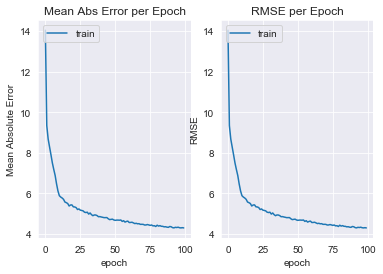

In [98]:
plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.title('Mean Abs Error per Epoch')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['rmse'])
plt.title('RMSE per Epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.subplot(1,2,2)
plt.show()

In [41]:
#mae: 4.2783

In [80]:
#MAE of around 4 w/m2. Considering DHI values go from 0 - 400, 4 represents a 1% error value

## IV. Model Validation - Outer Banks

In [55]:
validation_df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'outer_banks', 'r_banks.csv'))
validation_df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,timestamps,Cloud Cover
0,2018,1,1,0,30,1.8,0,0,0,4,...,0,85.84,119.89,0.03,1026,1.2,350,8.6,1514782800,1.00
1,2018,1,1,1,30,1.6,0,0,0,4,...,0,87.76,132.05,0.03,1026,1.2,348,8.7,1514786400,0.94
2,2018,1,1,2,30,1.5,0,0,0,4,...,0,88.35,144.19,0.03,1026,1.1,346,8.7,1514790000,1.00
3,2018,1,1,3,30,1.4,0,0,0,4,...,0,89.16,155.85,0.03,1026,1.1,346,8.7,1514793600,1.00
4,2018,1,1,4,30,1.4,0,0,0,4,...,0,89.52,165.32,0.03,1026,1.1,347,8.9,1514797200,1.00


In [56]:
input_size = 6
val_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
val_output_arry = np.array([], dtype=np.float64)
val_input_arry, val_output_arry = combine_training_arrays(validation_df, val_input_arry, val_output_arry)

In [57]:
#keras model.evaluate reveals a mae of 6.9433 w/m2 in the outer banks test

In [58]:
score = model.evaluate(val_input_arry, val_output_arry, verbose=1)

274/274 [==============================] - 0s 930us/step - loss: 246.7049 - mae: 6.7407


In [59]:
preds = model.predict(val_input_arry)

In [60]:
#Mape too high because of 0 values

In [61]:
#Compare random induvidual resutls!!!!!

In [62]:
i = randint(0,8760)
print("index is ",i)
print("Actual ",val_output_arry[i]," ","Predicted ", preds[i])

index is  68
Actual  44.0   Predicted  [46.71643]


In [42]:
model.save('Neural_Net_National')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Neural_Net_National/assets


## V. Model Testing - Other Locations

Lets take the global model and test in new locations. Lets test on the following locations for the year 2018.


1. Outer Banks (35.5585, -75.4665)
2. Miami Florida (25.7617, -80.1918)
3. Boulder CO (40.035,-105.54)
4. San Diego CA (32.7157, -117.1611)
5. Lincoln Nebraska (40.848,-96.56)
6. Quinault Washington (47.513,-123.81)
7. Old Town Maine (44.928,-68.70)
8. Murphey Idaho (43.204,-116.75)


In [27]:
#Test General model

In [34]:
National_model = keras.models.load_model('Neural_Net_National')

In [35]:
National_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2100      
_________________________________________________________________
dense_1 (Dense)              multiple                  60200     
_________________________________________________________________
dense_2 (Dense)              multiple                  20100     
_________________________________________________________________
dense_3 (Dense)              multiple                  5050      
_________________________________________________________________
dense_4 (Dense)              multiple                  1275      
_________________________________________________________________
dense_5 (Dense)              multiple                  26        
Total params: 88,751
Trainable params: 88,751
Non-trainable params: 0
____________________________________________________

In [39]:
test_files = ['Murphey_ID', 'OldTown_ME', 'Quinault_WA', 'Lincoln_NE', 'SanDiego_CA', 'Boulder_CO', 'Miami_FL', 'outer_banks']
scores = {}
for directory in test_files:
    for file in glob(_Testing_Data_Dir+'/'+directory+'/psm_*'):
        test_df = pd.read_csv(str(file))
        input_size = 6
        test_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
        test_output_arry = np.array([], dtype=np.float64)
        test_input_arry, test_output_arry = combine_training_arrays(test_df, test_input_arry, test_output_arry)
        print(directory)
        score = National_model.evaluate(test_input_arry, test_output_arry, verbose=1)
        scores['directory'] = score


Murphey_ID
274/274 [==============================] - 0s 981us/step - loss: 244.1408 - mean_absolute_error: 6.6758
OldTown_ME
274/274 [==============================] - 0s 872us/step - loss: 266.2828 - mean_absolute_error: 7.5486
Quinault_WA
274/274 [==============================] - 0s 855us/step - loss: 120.4911 - mean_absolute_error: 4.7218
Lincoln_NE
274/274 [==============================] - 0s 907us/step - loss: 196.3727 - mean_absolute_error: 6.0900
SanDiego_CA
274/274 [==============================] - 0s 851us/step - loss: 311.0495 - mean_absolute_error: 8.0326
Boulder_CO
274/274 [==============================] - 0s 858us/step - loss: 2019.3198 - mean_absolute_error: 18.3228
Miami_FL
274/274 [==============================] - 0s 857us/step - loss: 729.7203 - mean_absolute_error: 11.3716


In [59]:
#Only Miami and Boulder_CO seem to be outliers

## V.I Model Testing, Boulder Specific

Lets see if we can train a model specific for Boulder, CO and see if we can get the mae down.
Let's fetch more data from NRSDB and combine it with our readings from Darksky. Lets get data from 2008-2018.

In [48]:
input_size = 6
input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
output_arry = np.array([], dtype=np.float64)
print(input_arry)
print(output_arry)
from glob import glob
for path in glob(_Testing_Data_Dir+'/Boulder_CO'):
    for file in glob(path+'/psm_'+'*'):
        print(file)
        df = pd.read_csv(file)
        input_arry, output_arry = combine_training_arrays(df, input_arry, output_arry)

[]
[]
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2018.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2008.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2009.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2010.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2011.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2013.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2012.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2016.csv
/U

In [66]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [67]:
keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [68]:
model_Boulder = keras.Sequential()
model_Boulder.add(keras.layers.Dense(300, activation="relu"))
model_Boulder.add(layers.Dense(200, activation="relu"))
model_Boulder.add(layers.Dense(100, activation="relu"))
model_Boulder.add(layers.Dense(50, activation="relu"))
model_Boulder.add(layers.Dense(25, activation="relu"))
model_Boulder.add(layers.Dense(1, activation='relu'))

In [69]:
#Compile and train
model_Boulder.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae'])

history_Boulder = model_Boulder.fit(input_arry, output_arry, epochs=100, batch_size=32)

Epoch 1/100
3012/3012 [==============================] - 4s 1ms/step - loss: 2613.2988 - mae: 23.7973
Epoch 2/100
3012/3012 [==============================] - 4s 1ms/step - loss: 688.3729 - mae: 11.2140
Epoch 3/100
3012/3012 [==============================] - 5s 2ms/step - loss: 607.7477 - mae: 10.3038
Epoch 4/100
3012/3012 [==============================] - 4s 1ms/step - loss: 574.2565 - mae: 9.8747
Epoch 5/100
3012/3012 [==============================] - 4s 1ms/step - loss: 563.0343 - mae: 9.6770
Epoch 6/100
3012/3012 [==============================] - 4s 1ms/step - loss: 572.3027 - mae: 9.6235
Epoch 7/100
3012/3012 [==============================] - 5s 2ms/step - loss: 551.1252 - mae: 9.3266
Epoch 8/100
3012/3012 [==============================] - 8s 3ms/step - loss: 537.5186 - mae: 9.3029
Epoch 9/100
3012/3012 [==============================] - 6s 2ms/step - loss: 515.2476 - mae: 9.0313
Epoch 10/100
3012/3012 [==============================] - 5s 2ms/step - loss: 520.6798 - mae: 9.

In [70]:
#MAE falls to around 6.99

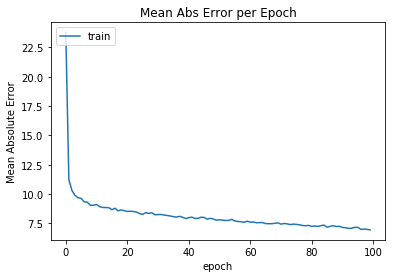

In [71]:
plt.plot(history_Boulder.history['mae'])
# plt.plot(history.history['val_acc'])
plt.title('Mean Abs Error per Epoch')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## V.II Model Testing,  Boulder Specific Model on Boulder 2018 data

Test on 2018 data only

In [72]:
test_df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'Boulder_CO', 'psm_CO_Boulder2018.csv'))
test_df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (285-385nm),timestamps,Cloud Cover
0,2018,1,1,0,30,-14.3,0,0,0,0,...,98.21,0.67,711,0.2,261,0.9,NaN,NaN,1514782800,0.00
1,2018,1,1,1,30,-15.6,0,0,0,0,...,109.06,0.67,711,0.2,254,1.2,NaN,NaN,1514786400,0.00
2,2018,1,1,2,30,-16.3,0,0,0,0,...,120.35,0.67,711,0.1,252,1.1,NaN,NaN,1514790000,0.64
3,2018,1,1,3,30,-16.7,0,0,0,0,...,131.81,0.67,711,0.1,256,1.0,NaN,NaN,1514793600,0.64
4,2018,1,1,4,30,-17.0,0,0,0,0,...,143.11,0.67,711,0.1,261,1.0,NaN,NaN,1514797200,0.64


In [73]:
input_size = 6
test_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
test_output_arry = np.array([], dtype=np.float64)
test_input_arry, test_output_arry = combine_training_arrays(test_df, test_input_arry, test_output_arry)

In [74]:
score = model_Boulder.evaluate(test_input_arry, test_output_arry, verbose=1)

274/274 [==============================] - 0s 961us/step - loss: 792.7593 - mae: 11.0128


In [75]:
#11.0128 is better than 15

## V.III Model Testing Miami Specific
Lets train on NRSDB + Darksky data from 08-18

In [9]:
input_size = 6
input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
output_arry = np.array([], dtype=np.float64)
print(input_arry)
print(output_arry)
from glob import glob
for path in glob(_Testing_Data_Dir+'/Miami_FL'):
    for file in glob(path+'/psm_'+'*'):
        print(file)
        df = pd.read_csv(file)
        input_arry, output_arry = combine_training_arrays(df, input_arry, output_arry)

[]
[]
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2009.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2008.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2018.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2017.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2016.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2014.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2015.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2011.csv
/Users/tuomastalvitie/Documents/GR

In [10]:
keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [12]:
model_Miami = keras.Sequential()
model_Miami.add(keras.layers.Dense(300, activation="relu"))
model_Miami.add(layers.Dense(200, activation="relu"))
model_Miami.add(layers.Dense(100, activation="relu"))
model_Miami.add(layers.Dense(50, activation="relu"))
model_Miami.add(layers.Dense(25, activation="relu"))
model_Miami.add(layers.Dense(1, activation='relu'))

In [15]:
#Compile and train
model_Miami.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae'])

history_Miami = model_Miami.fit(input_arry, output_arry, epochs=100, batch_size=64)

Epoch 1/100
1506/1506 [==============================] - 3s 2ms/step - loss: 2639.6416 - mae: 26.7736A: 0s - loss: 2700.1208 - mae: 27.19
Epoch 2/100
1506/1506 [==============================] - 3s 2ms/step - loss: 321.9077 - mae: 9.0803
Epoch 3/100
1506/1506 [==============================] - 3s 2ms/step - loss: 232.8395 - mae: 7.0399
Epoch 4/100
1506/1506 [==============================] - 3s 2ms/step - loss: 221.4184 - mae: 6.7184
Epoch 5/100
1506/1506 [==============================] - 3s 2ms/step - loss: 215.0308 - mae: 6.5356
Epoch 6/100
1506/1506 [==============================] - 3s 2ms/step - loss: 217.4235 - mae: 6.5626
Epoch 7/100
1506/1506 [==============================] - 3s 2ms/step - loss: 215.6544 - mae: 6.4743A: 0s - loss: 216.9443 - mae: 6.5
Epoch 8/100
1506/1506 [==============================] - 4s 2ms/step - loss: 205.0703 - mae: 6.2893
Epoch 9/100
1506/1506 [==============================] - 3s 2ms/step - loss: 205.5658 - mae: 6.2697
Epoch 10/100
1506/1506 [=====

In [16]:
#Mae down to 5.53

Test on Miami 2018 data

In [17]:
test_df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'Miami_FL', 'psm_FL_Miami2018.csv'))
test_df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (285-385nm),timestamps,Cloud Cover
0,2018,1,1,0,30,21.1,0,0,0,0,...,113.89,0.08,1019,2.7,58,2.0,NaN,NaN,1514782800,0.30
1,2018,1,1,1,30,21.2,0,0,0,0,...,127.06,0.08,1019,2.8,63,1.8,NaN,NaN,1514786400,0.32
2,2018,1,1,2,30,21.2,0,0,0,0,...,140.43,0.08,1019,2.8,65,1.6,NaN,NaN,1514790000,0.23
3,2018,1,1,3,30,21.2,0,0,0,0,...,153.91,0.08,1018,2.9,57,1.3,NaN,NaN,1514793600,0.14
4,2018,1,1,4,30,21.1,0,0,0,0,...,167.37,0.08,1018,2.9,41,1.1,NaN,NaN,1514797200,0.14


In [18]:
input_size = 6
test_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
test_output_arry = np.array([], dtype=np.float64)
test_input_arry, test_output_arry = combine_training_arrays(test_df, test_input_arry, test_output_arry)

In [20]:
score = model_Miami.evaluate(test_input_arry, test_output_arry, verbose=1)

274/274 [==============================] - 0s 951us/step - loss: 511.0820 - mae: 9.1866


In [21]:
#Mae of 9.1866....not bad!~